In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
from sklearn.model_selection import cross_val_score
from IPython.display import clear_output
%matplotlib inline

In [21]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.set_option('display.max_columns', 70)

/var/folders/zr/h5b56k9j30n0lmsx8g042cs40000gn/T/ipykernel_54939/4021082537.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [22]:
import matplotlib
matplotlib.rcParams['font.size'] = 16

In [23]:
def get_difference_to_value_at_18(df_svk_2018, feat_name):
    missing_to_value_at_18 = []
    average_values_for_years = get_average_value_for_feature_for_each_year(df_svk_2018, feat_name)
    last_value = average_values_for_years[-1]
    for value in average_values_for_years:
        missing_to_value_at_18.append((last_value-value))
    
    return missing_to_value_at_18

In [24]:
def get_sub_df_based_on_max_age(max_age = None, attributes = ['ATV'], df = None, final_column = False):
    min_age = 8
    final_age = 18
    df_new = pd.DataFrame()
    for attribute in attributes:
        selected_cols = []
        for i in range(min_age, max_age +1):
            selected_cols.append(attribute + '_' + str(i))
        if final_column:
            selected_cols.append(attribute + '_' + str(final_age))
        df_new = df_new.append(df[selected_cols].copy())
    return df_new

In [25]:
def get_average_value_for_feature_for_each_year(df_svk_2018, feat_name):
    df_features = df_svk_2018[([x for x in df_svk_2018.columns.tolist() if feat_name in x])].copy()
    average_value_for_years = []
    column_names = df_features.columns
    for i in range(0, len(column_names)):
        average = df_features[column_names[i]].median()
        average_value_for_years.append(average)
    return average_value_for_years

In [26]:
def add_features(df_svk_2018, df_no_feats, feat_name, current_year, all_final_values):
    #df = df_no_feats.copy()
    df = pd.DataFrame()
    #****
    df['last_value'] = df_no_feats[df_no_feats.columns[-1]]
    #****
    class_year = 18
    df['years_to_class'] = class_year - current_year
    #****
    all_current_values = df['last_value'].values
    percentiles = [percentileofscore(all_current_values, value) for value in df['last_value'].values]
    df['percentile'] = percentiles
    #****
    end_value_estimated = [np.percentile(all_final_values, current_percentile) for current_percentile in df['percentile'].values]
    df['end_value_estimated'] = end_value_estimated
    #****
    diffs = np.diff(df_no_feats.values, axis=1)
    new_col_names = []
    for i in range(0, len(df_no_feats.columns)-1):
        new_col_name = df_no_feats.columns[i+1] + '-' + df_no_feats.columns[i]
        df[new_col_name] = diffs[:,i]
        
    #***
    first_year = 8
    average_value_for_years = get_average_value_for_feature_for_each_year(df_svk_2018, feat_name)
    average_value_current = average_value_for_years[current_year - first_year]
    difference_to_average_value_current = [x-average_value_current for x in df['last_value'].values]
    df['difference_to_average_value_current'] = difference_to_average_value_current
    if (current_year - first_year -1) >=0:
        average_value_previous = average_value_for_years[current_year - first_year -1]
        difference_to_average_value_previous = [x-average_value_previous for x in df_no_feats[df_no_feats.columns[-2]].values]
        df['difference_to_average_value_previous'] = difference_to_average_value_previous
        #***
        df['diff_to_avg_change_previous_to_current'] = df['difference_to_average_value_current'] - df['difference_to_average_value_previous']
    if (current_year - first_year -2) >=0:
        average_value_before_previous = average_value_for_years[current_year - first_year -2]
        difference_to_average_value_before_previous = [x-average_value_before_previous for x in df_no_feats[df_no_feats.columns[-3]].values]
        df['difference_to_average_value_before_previous'] = difference_to_average_value_before_previous
        #***    
        df['diff_to_avg_change_before_previous_to_previous'] = df['difference_to_average_value_previous'] - df['difference_to_average_value_before_previous']
        df['trend'] = np.where(((df['diff_to_avg_change_previous_to_current']>0)&(df['diff_to_avg_change_before_previous_to_previous']>0)), 1, np.where(((df['diff_to_avg_change_previous_to_current']<0)&(df['diff_to_avg_change_before_previous_to_previous']<0)), -1, 0))
    #***
    if (diffs.shape[1]) > 0:
        df['last_difference'] = diffs[:,-1]
        df[feat_name + 'avg_diffs'] = np.mean(diffs, axis=1)
        df[feat_name + 'std_diffs'] = np.std(diffs, axis=1)
        df[feat_name + 'max_diffs'] = np.max(diffs, axis=1)
        if (current_year - first_year -2) >=0:
            df[feat_name + 'avg_diffs_last2'] = np.mean(diffs[:, [-2,-1]], axis=1)
    return df

In [27]:
def add_features_assisted(df_svk_2018, df_no_feats, feat_name, current_year, all_final_values):
    #df = df_no_feats.copy()
    df = pd.DataFrame()
    #****
    df['last_value'] = df_no_feats[df_no_feats.columns[-1]]
    #****
    class_year = 18
    #df['years_to_class'] = class_year - current_year
    #****
    all_current_values = df['last_value'].values
    percentiles = [percentileofscore(all_current_values, value) for value in df['last_value'].values]
    df['percentile'] = percentiles
    #****
    end_value_estimated = [np.percentile(all_final_values, current_percentile) for current_percentile in df['percentile'].values]
    df['end_value_estimated'] = end_value_estimated
    #****
    diffs = np.diff(df_no_feats.values, axis=1)
    new_col_names = []
    for i in range(0, len(df_no_feats.columns)-1):
        new_col_name = df_no_feats.columns[i+1] + '-' + df_no_feats.columns[i]
        df[new_col_name] = diffs[:,i]
    
    first_year = 8
    average_value_for_years = get_average_value_for_feature_for_each_year(df_svk_2018, feat_name)
    average_value_current = average_value_for_years[current_year - first_year]
    difference_to_average_value_current = [x-average_value_current for x in df['last_value'].values]
    df['difference_to_average_value_current'] = difference_to_average_value_current
    
    if (diffs.shape[1]) > 0:
        df['last_difference'] = diffs[:,-1]
        df[feat_name + 'avg_diffs'] = np.mean(diffs, axis=1)
        df[feat_name + 'std_diffs'] = np.std(diffs, axis=1)
        df[feat_name + 'max_diffs'] = np.max(diffs, axis=1)
        if (current_year - first_year -2) >=0:
            df[feat_name + 'avg_diffs_last2'] = np.mean(diffs[:, [-2,-1]], axis=1)
    return df

In [28]:
def get_basic_error(df, age=8, missing_to_value_at_18=None):
    age_index = age-8
    average_abs_basic_error = 0
    for index, row in df.iterrows():
        error = abs(row.iloc[age_index] + missing_to_value_at_18[age_index] - row.iloc[-1])
        average_abs_basic_error += error
        
    return average_abs_basic_error/len(df)  

In [29]:
def get_percentile_error(df, age=8):
    age_index = age-8
    average_abs_basic_error = 0
    all_current_values = df[df.columns[age_index]].values
    all_final_values = df[df.columns[-1]].values
    for index, row in df.iterrows():        
        current_percentile = percentileofscore(all_current_values, row.iloc[age_index])
        end_value_estimated = np.percentile(all_final_values, current_percentile)
        error = abs(end_value_estimated - row.iloc[-1])
        average_abs_basic_error += error
        
    return average_abs_basic_error/len(df)  

In [30]:
def calculate_baseline_values(df_svk_2018, feat_name):
    df_main = df_svk_2018[([x for x in df_svk_2018.columns.tolist() if feat_name in x])].copy()
    missing_to_value_at_18 = get_difference_to_value_at_18(df_svk_2018, feat_name)
    #Baseline
    mean_scores_basic = []
    for i in range(8,18):    
        mean_scores_basic.append(get_basic_error(df_main, age=i, missing_to_value_at_18 = missing_to_value_at_18))

    #Baseline percentile
    mean_scores_percentile = []
    for i in range(8,18):
        mean_scores_percentile.append(get_percentile_error(df_main, age=i))
        
    return mean_scores_basic, mean_scores_percentile

In [37]:
def get_scores(df_svk_2018, clf, feat_name, feat_name_assisted, keep_original_features=False):
    mean_scores = []
    df_main = df_svk_2018[([x for x in df_svk_2018.columns.tolist() if feat_name in x])].copy()
    all_final_values_main = df_main[df_main.columns[-1]].values
    df_assisted = df_svk_2018[([x for x in df_svk_2018.columns.tolist() if feat_name_assisted in x])].copy()    
    all_final_values_assisted = df_assisted[df_assisted.columns[-1]].values
    
    for i in range(8,18):
        df_temp_main = get_sub_df_based_on_max_age(max_age = i, attributes = [feat_name], df = df_svk_2018)
        df_temp_main_and_feat = add_features(df_svk_2018, df_temp_main, feat_name, i, all_final_values_main)
        #print(df_temp_main_and_feat.columns)
        
        df_temp_assisted = get_sub_df_based_on_max_age(max_age = i, attributes = [feat_name_assisted], df = df_svk_2018)
        df_temp_assisted_and_feat = add_features_assisted(df_svk_2018, df_temp_assisted, feat_name_assisted, i, all_final_values_assisted)
        
        df_temp_combined = df_temp_main_and_feat.join(df_temp_assisted_and_feat, rsuffix='_assisted')
        
        if keep_original_features:
            df_temp_combined = df_temp_combined.join(df_temp_main)
        
        '''
        #Adding region and municipality
        df_temp_combined['Region'] = df_svk_2018['Region']
        df_temp_combined['Municipality'] = df_svk_2018['Municipality']
        #print(df_temp_combined.head())
        '''
        
        X = np.asanyarray(df_temp_combined.values.tolist())
        y = np.ravel(all_final_values_main.tolist())
        
        mean_score = cross_val_score(clf, X, y, cv=5, scoring='neg_mean_absolute_error').mean() * (-1)
        mean_scores.append(mean_score)
    return mean_scores

In [31]:
def present_results(df_svk_2018, feat_name, feat_name_assisted):
    #Linear Regresion
    from sklearn.linear_model import LinearRegression
    lin_regr = LinearRegression()
    mean_scores_lin_regr = get_scores(df_svk_2018, lin_regr, feat_name, feat_name_assisted)
    print ('Average error for Lin. regr. for ' + feat_name + ' is: ' + str(sum(mean_scores_lin_regr)))
    #XGB
    from xgboost import XGBRegressor
    xgb_regr = XGBRegressor()
    mean_scores_xgb_regr = get_scores(df_svk_2018, xgb_regr, feat_name, feat_name_assisted)
    print ('Average error for XGB for ' + feat_name + ' is: ' + str(sum(mean_scores_xgb_regr)))
    xgb_regr = XGBRegressor(n_estimators=200, learning_rate=0.05, subsample=0.5, colsample_bytree = 0.65)
    mean_scores_xgb_regr = get_scores(df_svk_2018, xgb_regr, feat_name, feat_name_assisted)
    print ('Average error for BEST XGB for ' + feat_name + ' is: ' + str(sum(mean_scores_xgb_regr)))
    #DT
    from sklearn.tree import DecisionTreeRegressor
    dt_regr = DecisionTreeRegressor()
    mean_scores_dt_regr = get_scores(df_svk_2018, dt_regr, feat_name, feat_name_assisted)
    print ('Average error for DT for ' + feat_name + ' is: ' + str(sum(mean_scores_dt_regr)))
    #Benchmarks
    mean_scores_basic, mean_scores_percentile = calculate_baseline_values(df_svk_2018, feat_name)
    print ('Average error for mean basic for ' + feat_name + ' is: ' + str(sum(mean_scores_basic)))
    print ('Average error for percentile basic for ' + feat_name + ' is: ' + str(sum(mean_scores_percentile)))
    
    #Draw results
    bigest_value = max(max(mean_scores_lin_regr), max(mean_scores_dt_regr), max(mean_scores_xgb_regr), max(mean_scores_basic)) + 5
    x_tics = range(8,18)
    plt.figure(figsize=(14, 6))
    plt.ylim(0, bigest_value)
    plt.plot(x_tics, mean_scores_lin_regr, label="Linear regression", linewidth=2)
    plt.plot(x_tics, mean_scores_dt_regr, label="Decision tree regressor", linewidth=2)
    plt.plot(x_tics, mean_scores_xgb_regr, label="XGB", linewidth=2)
    plt.plot(x_tics, mean_scores_basic, label="Baseline average growths", linewidth=2)
    plt.plot(x_tics, mean_scores_percentile, label="Baseline percentiles", linewidth=2)
    plt.xlabel("Age")
    plt.ylabel("Average predicted error")
    plt.title("Predicting " + feat_name + " at 18 years")
    plt.legend()
    plt.show()

In [34]:
df_svk_2018_mens = pd.read_csv('../data/svk_height_weight_mens_2018_v2.csv',sep=',', index_col=0)
print('Number of men: ' + str(len(df_svk_2018_mens)))
df_svk_2018_women = pd.read_csv('../data/svk_height_weight_womens_2018_v2.csv',sep=',', index_col=0)
print('Number of women: ' + str(len(df_svk_2018_women)))

Number of men: 7577
Number of women: 9181


/var/folders/zr/h5b56k9j30n0lmsx8g042cs40000gn/T/ipykernel_54939/3847091870.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(df[selected_cols].copy())
/var/folders/zr/h5b56k9j30n0lmsx8g042cs40000gn/T/ipykernel_54939/3847091870.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(df[selected_cols].copy())
/var/folders/zr/h5b56k9j30n0lmsx8g042cs40000gn/T/ipykernel_54939/3847091870.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(df[selected_cols].copy())
/var/folders/zr/h5b56k9j30n0lmsx8g042cs40000gn/T/ipykernel_54939/3847091870.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

Average error for Lin. regr. for ATV is: 260.84551632253863


/Users/miha/opt/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/var/folders/zr/h5b56k9j30n0lmsx8g042cs40000gn/T/ipykernel_54939/3847091870.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(df[selected_cols].copy())
/var/folders/zr/h5b56k9j30n0lmsx8g042cs40000gn/T/ipykernel_54939/3847091870.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(df[selected_cols].copy())
/var/folders/zr/h5b56k9j30n0lmsx8g042cs40000gn/T/ipykernel_54939/3847091870.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

Average error for XGB for ATV is: 265.3643828955303
Average error for BEST XGB for ATV is: 265.3643828955303


/var/folders/zr/h5b56k9j30n0lmsx8g042cs40000gn/T/ipykernel_54939/3847091870.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(df[selected_cols].copy())
/var/folders/zr/h5b56k9j30n0lmsx8g042cs40000gn/T/ipykernel_54939/3847091870.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(df[selected_cols].copy())
/var/folders/zr/h5b56k9j30n0lmsx8g042cs40000gn/T/ipykernel_54939/3847091870.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(df[selected_cols].copy())
/var/folders/zr/h5b56k9j30n0lmsx8g042cs40000gn/T/ipykernel_54939/3847091870.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

With PHV Average error for BEST XGB for ATV is: 250.11913791140316


/var/folders/zr/h5b56k9j30n0lmsx8g042cs40000gn/T/ipykernel_54939/3847091870.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(df[selected_cols].copy())
/var/folders/zr/h5b56k9j30n0lmsx8g042cs40000gn/T/ipykernel_54939/3847091870.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(df[selected_cols].copy())
/var/folders/zr/h5b56k9j30n0lmsx8g042cs40000gn/T/ipykernel_54939/3847091870.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(df[selected_cols].copy())
/var/folders/zr/h5b56k9j30n0lmsx8g042cs40000gn/T/ipykernel_54939/3847091870.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

Average error for DT for ATV is: 359.86814213817223
Average error for percentile basic for ATV is: 328.3784395873524
Average error for line method is: 226.1686130536125


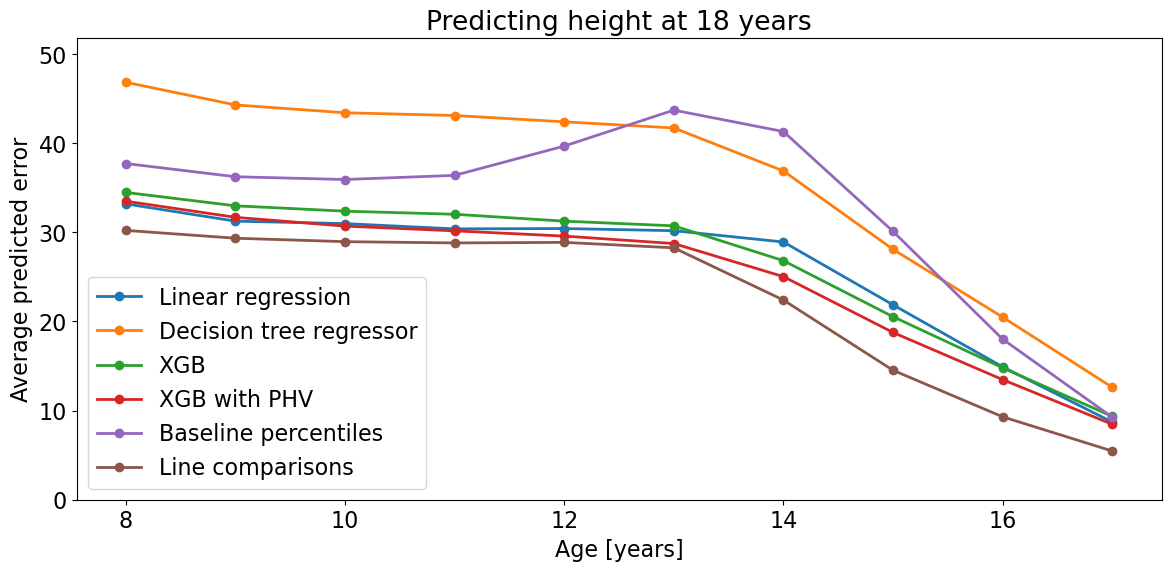

In [39]:
    #Draw results for paper
    feat_name = 'ATV'
    feat_name_assisted = 'ATT'
    #Use men's df
    #df_svk_2018 = df_svk_2018_women
    #classifier_PHV = clf_xgb_womens
    df_svk_2018 = df_svk_2018_mens
    #classifier_PHV = clf_xgb_mens
    
    from sklearn.linear_model import LinearRegression
    lin_regr = LinearRegression()
    mean_scores_lin_regr = get_scores(df_svk_2018, lin_regr, 'ATV', 'ATT')
    print ('Average error for Lin. regr. for ' + 'ATV' + ' is: ' + str(sum(mean_scores_lin_regr)))
    
    from xgboost import XGBRegressor
    xgb_regr = XGBRegressor()
    mean_scores_xgb_regr = get_scores(df_svk_2018, xgb_regr, feat_name, feat_name_assisted)
    print ('Average error for XGB for ' + feat_name + ' is: ' + str(sum(mean_scores_xgb_regr)))
    #xgb_regr = XGBRegressor(n_estimators=200, learning_rate=0.05, subsample=0.5, colsample_bytree = 0.65)
    #mean_scores_xgb_regr = get_scores(df_svk_2018, xgb_regr, feat_name, feat_name_assisted)
    print ('Average error for BEST XGB for ' + feat_name + ' is: ' + str(sum(mean_scores_xgb_regr)))
    
    from xgboost import XGBRegressor
    xgb_regr = XGBRegressor()
    #mean_scores_xgb_regr_with_PHV = get_scores_with_PHV(df_svk_2018, xgb_regr, feat_name, feat_name_assisted, classifier_PHV)
    #print ('With PHV Average error for XGB for ' + feat_name + ' is: ' + str(sum(mean_scores_xgb_regr_with_PHV)))
    xgb_regr = XGBRegressor(n_estimators=200, learning_rate=0.05, subsample=0.5, colsample_bytree = 0.65)
    mean_scores_xgb_regr_with_PHV = get_scores(df_svk_2018, xgb_regr, feat_name, feat_name_assisted)
    print ('With PHV Average error for BEST XGB for ' + feat_name + ' is: ' + str(sum(mean_scores_xgb_regr_with_PHV)))
    
    from sklearn.tree import DecisionTreeRegressor
    dt_regr = DecisionTreeRegressor()
    mean_scores_dt_regr = get_scores(df_svk_2018, dt_regr, feat_name, feat_name_assisted)
    print ('Average error for DT for ' + feat_name + ' is: ' + str(sum(mean_scores_dt_regr)))
    
    #Benchmarks
    mean_scores_basic, mean_scores_percentile = calculate_baseline_values(df_svk_2018, feat_name)
    print ('Average error for percentile basic for ' + feat_name + ' is: ' + str(sum(mean_scores_percentile)))
    
    print ('Average error for line method is: 226.1686130536125')
    
    #Draw results
    bigest_value = max(max(mean_scores_lin_regr), max(mean_scores_dt_regr), max(mean_scores_xgb_regr), max(mean_scores_percentile)) + 5
    x_tics = range(8,18)
    plt.figure(figsize=(14, 6))
    plt.ylim(0, bigest_value)
    plt.plot(x_tics, mean_scores_lin_regr, 'o-', label="Linear regression", linewidth=2)
    plt.plot(x_tics, mean_scores_dt_regr, 'o-', label="Decision tree regressor", linewidth=2)
    plt.plot(x_tics, mean_scores_xgb_regr, 'o-', label="XGB", linewidth=2)
    plt.plot(x_tics, mean_scores_xgb_regr_with_PHV, 'o-', label="XGB with PHV", linewidth=2)
    plt.plot(x_tics, mean_scores_percentile, 'o-', label="Baseline percentiles", linewidth=2)
    #line comparisons
    line_comp = [30.218531468531637, 29.34230769230612, 28.95545454545504, 28.812575757575587, 28.876025641026445, 28.26538461538462, 22.401666666665506, 14.525000000000091, 9.303333333334876, 5.468333333332566]
    plt.plot(x_tics, line_comp, 'o-', label="Line comparisons", linewidth=2)
    plt.xlabel("Age [years]")
    plt.ylabel("Average predicted error")
    plt.title("Predicting height at 18 years")
    plt.legend()
    plt.show()

In [40]:
print('Mens')
print(f'Lin_regr: {mean_scores_lin_regr}')
print(f'DT: {mean_scores_dt_regr}')
print(f'XGB: {mean_scores_xgb_regr}')
print(f'XGB with PHV: {mean_scores_xgb_regr_with_PHV}')
print(f'Percentile: {mean_scores_percentile}')
print(f'Line method: {line_comp}')

Mens
Lin_regr: [33.194396818975044, 31.257107445776036, 30.981517521601962, 30.390242476506888, 30.4278506986531, 30.18696362669553, 28.919949861378434, 21.867471545193393, 14.907809433890495, 8.712206893867798]
DT: [46.83842956781833, 44.29725855176344, 43.41875436452718, 43.1113902224909, 42.400150390318124, 41.71407033579347, 36.88867230532672, 28.09610869692611, 20.48563861206499, 12.61766909114293]
XGB: [34.47735532479518, 32.9776836167055, 32.37654640727481, 32.028550862908716, 31.25635141031546, 30.732398999063435, 26.821499285066018, 20.53639566323768, 14.80364280630566, 9.353958519857828]
XGB with PHV: [33.496843120166226, 31.68645566240183, 30.701076953269443, 30.16868234684951, 29.581006850588995, 28.742628311692915, 25.03304043251771, 18.769438679865427, 13.474348261399134, 8.465617292651954]
Percentile: [37.72078786062763, 36.23886694878359, 35.92913433278443, 36.39376210812392, 39.68192823801178, 43.71537170749657, 41.31142773839081, 30.10612773548653, 18.021366119320675,

Average error for Lin. regr. for ATV is: 234.77356604155975
Average error for XGB for ATV is: 221.24715152638072
Average error for BEST XGB for ATV is: 221.24715152638072
With PHV Average error for BEST XGB for ATV is: 220.12029568600957
Average error for DT for ATV is: 323.6665367460966
Average error for line method is: 185.94520979021354
Average error for percentile basic for ATV is: 285.67111431401014


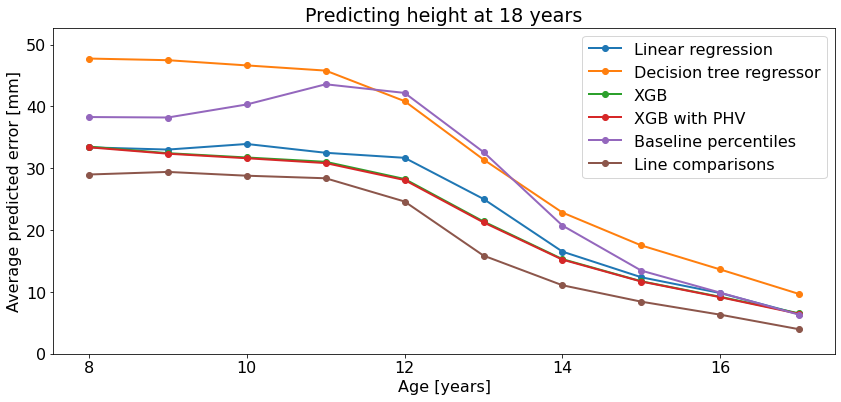

In [37]:
    #Draw results for paper
    feat_name = 'ATV'
    feat_name_assisted = 'ATT'
    #use womens df
    df_svk_2018 = df_svk_2018_women
    #classifier_PHV = clf_xgb_womens
    #df_svk_2018 = df_svk_2018_mens
    #classifier_PHV = clf_xgb_mens
    
    from sklearn.linear_model import LinearRegression
    lin_regr = LinearRegression()
    mean_scores_lin_regr = get_scores(df_svk_2018, lin_regr, 'ATV', 'ATT')
    print ('Average error for Lin. regr. for ' + 'ATV' + ' is: ' + str(sum(mean_scores_lin_regr)))
    
    from xgboost import XGBRegressor
    xgb_regr = XGBRegressor()
    mean_scores_xgb_regr = get_scores(df_svk_2018, xgb_regr, feat_name, feat_name_assisted)
    print ('Average error for XGB for ' + feat_name + ' is: ' + str(sum(mean_scores_xgb_regr)))
    #xgb_regr = XGBRegressor(n_estimators=200, learning_rate=0.05, subsample=0.5, colsample_bytree = 0.65)
    #mean_scores_xgb_regr = get_scores(df_svk_2018, xgb_regr, feat_name, feat_name_assisted)
    print ('Average error for BEST XGB for ' + feat_name + ' is: ' + str(sum(mean_scores_xgb_regr)))
    
    from xgboost import XGBRegressor
    xgb_regr = XGBRegressor()
    #mean_scores_xgb_regr_with_PHV = get_scores_with_PHV(df_svk_2018, xgb_regr, feat_name, feat_name_assisted, classifier_PHV)
    #print ('With PHV Average error for XGB for ' + feat_name + ' is: ' + str(sum(mean_scores_xgb_regr_with_PHV)))
    xgb_regr = XGBRegressor(n_estimators=200, learning_rate=0.05, subsample=0.5, colsample_bytree = 0.65)
    mean_scores_xgb_regr_with_PHV = get_scores(df_svk_2018, xgb_regr, feat_name, feat_name_assisted)
    print ('With PHV Average error for BEST XGB for ' + feat_name + ' is: ' + str(sum(mean_scores_xgb_regr_with_PHV)))
    
    from sklearn.tree import DecisionTreeRegressor
    dt_regr = DecisionTreeRegressor()
    mean_scores_dt_regr = get_scores(df_svk_2018, dt_regr, feat_name, feat_name_assisted)
    print ('Average error for DT for ' + feat_name + ' is: ' + str(sum(mean_scores_dt_regr)))
    
    print ('Average error for line method is: 185.94520979021354')
    
    #Benchmarks
    mean_scores_basic, mean_scores_percentile = calculate_baseline_values(df_svk_2018, feat_name)
    print ('Average error for percentile basic for ' + feat_name + ' is: ' + str(sum(mean_scores_percentile)))
    
    #Draw results
    bigest_value = max(max(mean_scores_lin_regr), max(mean_scores_dt_regr), max(mean_scores_xgb_regr), max(mean_scores_percentile)) + 5
    x_tics = range(8,18)
    plt.figure(figsize=(14, 6))
    plt.ylim(0, bigest_value)
    plt.plot(x_tics, mean_scores_lin_regr, 'o-', label="Linear regression", linewidth=2)
    plt.plot(x_tics, mean_scores_dt_regr, 'o-', label="Decision tree regressor", linewidth=2)
    plt.plot(x_tics, mean_scores_xgb_regr, 'o-', label="XGB", linewidth=2)
    plt.plot(x_tics, mean_scores_xgb_regr_with_PHV, 'o-', label="XGB with PHV", linewidth=2)
    plt.plot(x_tics, mean_scores_percentile, 'o-', label="Baseline percentiles", linewidth=2)
    #line comparisons
    line_comp = [29.000000000000682, 29.41833333333352, 28.805000000000973, 28.39166666666688, 24.631212121211775, 15.88287878787969, 11.08666666666727, 8.4300000000012, 6.327016317016387, 3.9724358974351617]
    plt.plot(x_tics, line_comp, 'o-', label="Line comparisons", linewidth=2)
    plt.xlabel("Age [years]")
    plt.ylabel("Average predicted error [mm]")
    plt.title("Predicting height at 18 years")
    plt.legend()
    plt.show()

In [41]:
print('Womens')
print(f'Lin_regr: {mean_scores_lin_regr}')
print(f'DT: {mean_scores_dt_regr}')
print(f'XGB: {mean_scores_xgb_regr}')
print(f'XGB with PHV: {mean_scores_xgb_regr_with_PHV}')
print(f'Percentile: {mean_scores_percentile}')
print(f'Line method: {line_comp}')

Womens
Lin_regr: [33.39032020381948, 33.03399778059029, 33.937263371143004, 32.51301179615657, 31.69965794513551, 25.043876209014062, 16.5285649108909, 12.377905130450912, 9.825573963874328, 6.423394730484714]
DT: [47.75453750104466, 47.4892718594282, 46.64569244051815, 45.80628274639476, 40.86529701287417, 31.41989604855265, 22.84472647908959, 17.526177637647212, 13.641015930278346, 9.67363909026885]
XGB: [33.511625914324, 32.45046245284636, 31.75277929380611, 31.052244758014915, 28.275340056787854, 21.40062038414061, 15.313686100200764, 11.731417262841978, 9.21604889238408, 6.542926411034051]
XGB with PHV: [33.39755781746024, 32.36376182001965, 31.630731175002456, 30.848001485316008, 28.10638002964929, 21.253146022534725, 15.230130279166627, 11.686546615001536, 9.151388696070935, 6.452651745788117]
Percentile: [38.29448790446728, 38.21895130863233, 40.32913168730544, 43.59439674038937, 42.19589896785761, 32.62802049141661, 20.743743592959053, 13.453306706627842, 9.890828676231912, 6.